# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I5, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
    - C (hand-written)
    - C (hand-written with -ffast-math)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [1]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Vector{Float64}:
 0.7062505525842386
 0.43095349843453346
 0.9254768913370333
 0.10274483085167274
 0.0229717169149789
 0.598372820436295
 0.7604596241334093
 0.14614597288541953
 0.5187287991799919
 0.5696422359282141
 0.1911419334043768
 0.8204057921196518
 0.6664537795154484
 ⋮
 0.9457426032909053
 0.15830135582738092
 0.18144883195749295
 0.5329348548703651
 0.6625834859494136
 0.8478289317566885
 0.47295112881599244
 0.8952300201384227
 0.6382572727754113
 0.028095261438549235
 0.07936373624410431
 0.5503938001859844

In [2]:
sum(a)

4.999149674811354e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

In [6]:
@time sum(a)

  0.001191 seconds (1 allocation: 16 bytes)


4.999149674811354e6

In [7]:
@time sum(a)

  0.001701 seconds (1 allocation: 16 bytes)


4.999149674811354e6

In [8]:
@time sum(a)

  0.001201 seconds (1 allocation: 16 bytes)


4.999149674811354e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [9]:
using Pkg
Pkg.add("BenchmarkTools")

    Updating registry at `~/.julia/registries/JuliaComputingRegistry`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


In [10]:
using BenchmarkTools  

In [11]:
@benchmark sum($a)

BenchmarkTools.Trial: 5354 samples with 1 evaluation per sample.
 Range (min … max):  874.334 μs …  10.677 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     908.145 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   929.213 μs ± 156.276 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁▆██▇▇▇▆▆▆▆▅▅▄▄▃▂▁▁▁▁  ▁▁                                     ▂
  ███████████████████████████▇▇▇▇█▇██▆█▇████▆▅▅▅▅▅▅▄▅▆▅▅▅▄▄▄▄▅▄ █
  874 μs        Histogram: log(frequency) by time       1.19 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [13]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
     size_t i;
    for ( i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC  -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [14]:
c_sum(a)

4.999149674811348e6

In [15]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [16]:
c_sum(a) - sum(a)  

-5.587935447692871e-9

In [17]:
≈  # alias for the `isapprox` function

isapprox (generic function with 13 methods)

In [18]:
?isapprox

search: isapprox isperm iszero



```
isapprox(x, y; atol::Real=0, rtol::Real=atol>0 ? 0 : √eps, nans::Bool=false[, norm::Function])
```

Inexact equality comparison. Two numbers compare equal if their relative distance *or* their absolute distance is within tolerance bounds: `isapprox` returns `true` if `norm(x-y) <= max(atol, rtol*max(norm(x), norm(y)))`. The default `atol` (absolute tolerance) is zero and the default `rtol` (relative tolerance) depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, if an `atol > 0` is not specified, `rtol` defaults to the square root of [`eps`](@ref) of the type of `x` or `y`, whichever is bigger (least precise). This corresponds to requiring equality of about half of the significant digits. Otherwise, e.g. for integer arguments or if an `atol > 0` is supplied, `rtol` defaults to zero.

The `norm` keyword defaults to `abs` for numeric `(x,y)` and to `LinearAlgebra.norm` for arrays (where an alternative `norm` choice is sometimes useful). When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

Note that `x ≈ 0` (i.e., comparing to zero with the default tolerances) is equivalent to `x == 0` since the default `atol` is `0`.  In such cases, you should either supply an appropriate `atol` (or use `norm(x) ≤ atol`) or rearrange your code (e.g. use `x ≈ y` rather than `x - y ≈ 0`).   It is not possible to pick a nonzero `atol` automatically because it depends on the overall scaling (the "units") of your problem: for example, in `x - y ≈ 0`, `atol=1e-9` is an absurdly small tolerance if `x` is the [radius of the Earth](https://en.wikipedia.org/wiki/Earth_radius) in meters, but an absurdly large tolerance if `x` is the [radius of a Hydrogen atom](https://en.wikipedia.org/wiki/Bohr_radius) in meters.

!!! compat "Julia 1.6"
    Passing the `norm` keyword argument when comparing numeric (non-array) arguments requires Julia 1.6 or later.


# Examples

```jldoctest
julia> isapprox(0.1, 0.15; atol=0.05)
true

julia> isapprox(0.1, 0.15; rtol=0.34)
true

julia> isapprox(0.1, 0.15; rtol=0.33)
false

julia> 0.1 + 1e-10 ≈ 0.1
true

julia> 1e-10 ≈ 0
false

julia> isapprox(1e-10, 0, atol=1e-8)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0]) # using `norm`
true
```

---

```
isapprox(x; kwargs...) / ≈(x; kwargs...)
```

Create a function that compares its argument to `x` using `≈`, i.e. a function equivalent to `y -> y ≈ x`.

The keyword arguments supported here are the same as those in the 2-argument `isapprox`.

!!! compat "Julia 1.5"
    This method requires Julia 1.5 or later.



We can now benchmark the C code directly from Julia:

In [19]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 667 samples with 1 evaluation per sample.
 Range (min … max):  7.398 ms …   8.537 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     7.447 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   7.504 ms ± 166.799 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▄███▅▃▁▁ ▁                                                   
  ██████████▆█▆▇▅▆▅▇▅▄▇▅▅▆▇▆▅▁▄▆▆▅▄▄▄▄▅▄▅▁▆▅▅▅▁▁▁▄▄▄▁▁▁▁▁▁▁▁▄ ▇
  7.4 ms       Histogram: log(frequency) by time      8.33 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [20]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 7.397916 msec


In [21]:
d = Dict()  # a "dictionary", i.e. an associative array

Dict{Any, Any}()

In [22]:
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any, Any} with 1 entry:
  "C" => 7.39792

In [23]:
using LibCURL

In [24]:
Pkg.add("Plots")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


In [25]:
Pkg.build("Plots")

In [26]:
using Plots


In [27]:
#use GR ploting backend

gr()

Plots.GRBackend()

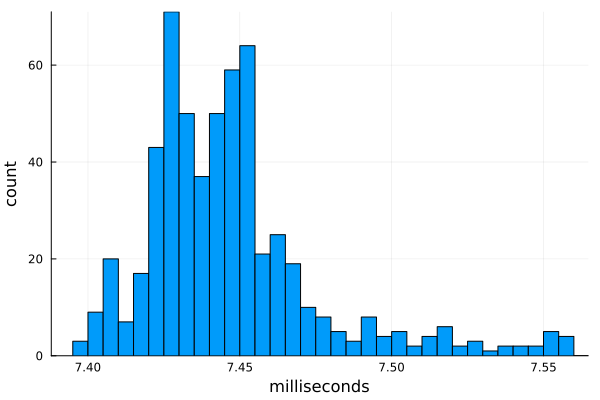

In [28]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
        xlim=(m - 0.01, m + σ),
        xlabel="milliseconds", ylabel="count", label="")

# 2. C with -ffast-math

If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.

In [30]:
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3  -march=native -mtune=native -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [31]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 5325 samples with 1 evaluation per sample.
 Range (min … max):  912.000 μs …  1.361 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     926.375 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   936.073 μs ± 33.877 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▂▅███▆▆▅▄▄▄▃▂▁▁▁▁                                            ▂
  ███████████████████▇▇▇▇▇▅▅▇▇▆▆▆▆▆▃▆▅▆▅▆▃▄▅▃▆▅▅▄▅▄▃▄▃▃▄▅▃▄▃▃▅ █
  912 μs        Histogram: log(frequency) by time       1.1 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [32]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds

0.912

# 3. Python's built in `sum` 

The `PythonCall` package provides a Julia interface to Python:

In [37]:
using Pkg; Pkg.add("PythonCall")
using PythonCall

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


In [39]:
names(PythonCall)

151-element Vector{Symbol}:
 Symbol("@py")
 Symbol("@pyconst")
 Symbol("@pyconvert")
 Symbol("@pyeval")
 Symbol("@pyexec")
 :CONFIG
 :GC
 :GIL
 :PYCONVERT_PRIORITY_ARRAY
 :PYCONVERT_PRIORITY_CANONICAL
 :PYCONVERT_PRIORITY_FALLBACK
 :PYCONVERT_PRIORITY_NORMAL
 :PYCONVERT_PRIORITY_WRAP
 ⋮
 :python_executable_path
 :python_library_handle
 :python_library_path
 :python_version
 :pytime
 :pytruediv
 :pytruth
 :pytuple
 :pytype
 :pywith
 :pyxor
 :unsafe_pynext

In [46]:
# get the Python built-in "sum" function:
# pysum = pybuiltin("sum") # for PyCall
pysum  = pybuiltins.sum

Python: <built-in function sum>

In [41]:
pysum(a)

Python: 4999149.674811353

In [48]:
pyconvert(Float64, pysum(a))

4.999149674811353e6

In [49]:
pyconvert(Float64, pysum(a)) ≈ sum(a)

true

In [50]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 1 sample with 1 evaluation per sample.
 Single result which took 5.548 s (7.09% GC) to evaluate,
 with a memory estimate of 2.98 GiB, over 149998503 allocations.

In [51]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "C"               => 7.39792
  "Python built-in" => 5548.23
  "C -ffast-math"   => 0.912

# 4. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [59]:
using PythonCall

In [55]:
numpy = pyimport("numpy")

Python: <module 'numpy' from '/Users/jebalunode/.julia/environments/v1.11/.CondaPkg/.pixi/envs/default/lib/python3.13/site-packages/numpy/__init__.py'>

In [57]:
numpy_sum= numpy.sum

Python: <function sum at 0x36f1f29b0>

In [60]:
 

py_numpy_bench = @benchmark $numpy_sum($a)

BenchmarkTools.Trial: 2790 samples with 1 evaluation per sample.
 Range (min … max):  1.660 ms …  2.430 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.792 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.791 ms ± 47.538 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                           ▅█▅▄▄▄▆▄▃▃▁                        
  ▂▁▂▂▂▂▂▃▂▄▄▅▅▄▅▅▆▅▅▅▄▅▅▇▇███████████▇▆▅▅▄▃▃▂▂▂▃▂▂▁▂▁▂▂▂▂▂▂ ▄
  1.66 ms        Histogram: frequency by time        1.93 ms <

 Memory estimate: 1.25 KiB, allocs estimate: 51.

In [61]:
numpy_sum(a)

Python: np.float64(4999149.674811354)

In [65]:
pyconvert(Float64, numpy_sum(a))

4.999149674811354e6

In [66]:
pyconvert(Float64, numpy_sum(a)) ≈ sum(a)

true

In [67]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any, Any} with 4 entries:
  "C"               => 7.39792
  "Python numpy"    => 1.66046
  "Python built-in" => 5548.23
  "C -ffast-math"   => 0.912

# 5. Python, hand-written 

In [122]:
using PythonCall

@pyexec """
def sum_py(A):
    s = 0.0
    for a in A:
        s += a
    return s
""" => sum_py # The => sum_py makes  the python function available in Julia as `sum_py`

Python: <function sum_py at 0x363292de0>

In [123]:
sum_py(a)

Python: 4999149.674811348

In [124]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 1 sample with 1 evaluation per sample.
 Single result which took 5.968 s (7.26% GC) to evaluate,
 with a memory estimate of 2.98 GiB, over 149998503 allocations.

In [127]:
pyconvert(Float64, sum_py(a))

4.999149674811348e6

In [125]:
pyconvert(Float64, sum_py(a)) ≈ sum(a)

true

In [129]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any, Any} with 8 entries:
  "Julia hand-written simd" => 0.922125
  "C"                       => 7.39792
  "Python numpy"            => 1.66046
  "Julia hand-written"      => 6.58596
  "Python hand-written"     => 5968.32
  "Python built-in"         => 5548.23
  "Julia built-in"          => 0.873833
  "C -ffast-math"           => 0.912

# 6. Julia (built-in) 

## Written directly in Julia, not in C!

In [105]:
@which sum(a)

sum(a::AbstractArray; dims, kw...)
     @ Base reducedim.jl:982

In [106]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 5515 samples with 1 evaluation per sample.
 Range (min … max):  873.833 μs …  1.318 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     893.417 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   903.595 μs ± 33.571 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▄▇█▅▃▁                                                      
  ▂▅███████▇▆▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  874 μs          Histogram: frequency by time         1.06 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [107]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any, Any} with 5 entries:
  "C"               => 7.39792
  "Python numpy"    => 1.66046
  "Python built-in" => 5548.23
  "Julia built-in"  => 0.873833
  "C -ffast-math"   => 0.912

# 7. Julia (hand-written) 

In [111]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [112]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 739 samples with 1 evaluation per sample.
 Range (min … max):  6.586 ms …   7.788 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     6.751 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   6.769 ms ± 118.787 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

           ▃▂▂▆▆▄▆▆█▄▄                                         
  ▃▃▄▃▇▇▆▇████████████▇▅▇▄▅▅▃▄▃▂▃▃▃▁▂▂▂▂▂▂▁▂▂▁▃▂▂▃▃▂▂▂▁▃▃▂▂▂▂ ▄
  6.59 ms         Histogram: frequency by time        7.22 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [113]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any, Any} with 6 entries:
  "C"                  => 7.39792
  "Python numpy"       => 1.66046
  "Julia hand-written" => 6.58596
  "Python built-in"    => 5548.23
  "Julia built-in"     => 0.873833
  "C -ffast-math"      => 0.912

# 8. Julia (hand-written w. simd) 

In [114]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [115]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 5245 samples with 1 evaluation per sample.
 Range (min … max):  922.125 μs …  1.392 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     938.250 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   950.422 μs ± 34.292 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▅█▆▁                                                        
  ▂▅████▇▅▅▄▄▄▄▃▃▃▂▂▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  922 μs          Histogram: frequency by time         1.09 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [116]:
mysum_simd(a)

4.999149674811177e6

In [117]:
mysum_simd(a) ≈ sum(a)

true

In [118]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any, Any} with 7 entries:
  "Julia hand-written simd" => 0.922125
  "C"                       => 7.39792
  "Python numpy"            => 1.66046
  "Julia hand-written"      => 6.58596
  "Python built-in"         => 5548.23
  "Julia built-in"          => 0.873833
  "C -ffast-math"           => 0.912

# Summary

In [119]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

Julia built-in..............0.9
C -ffast-math...............0.9
Julia hand-written simd.....0.9
Python numpy................1.7
Julia hand-written..........6.6
C...........................7.4
Python built-in..........5548.2
